Name: Zixi Wang

Github Username: lacunaxu

USC ID: 2854187591

In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from albumentations import Compose, RandomCrop, Resize, RandomBrightnessContrast, ShiftScaleRotate, HorizontalFlip
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def load_images_and_labels(data_path, image_size):
    class_names = sorted([folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))])
    images = []
    labels = []
    class_mapping = {name: idx for idx, name in enumerate(class_names)}
    print(f"Classes: {class_mapping}")

    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            img = cv2.imread(file_path)
            if img is None:  # Skip invalid images
                continue
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(class_mapping[class_name])

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(class_names))
    return images, labels, class_mapping

overall_path = os.getcwd()
new_path = os.path.dirname(overall_path)
train_path = os.path.join(new_path, 'data', 'seg_train', 'seg_train')
test_path = os.path.join(new_path, 'data', 'seg_test', 'seg_test')

image_size = (224, 224)

train_images, train_labels, train_class_mapping = load_images_and_labels(train_path, image_size)
print(f"training data complete: {train_images.shape}, {train_labels.shape}")

test_images, test_labels, test_class_mapping = load_images_and_labels(test_path, image_size)
print(f"test data complete: {test_images.shape}, {test_labels.shape}")

Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
training data complete: (14034, 224, 224, 3), (14034, 6)
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
test data complete: (3000, 224, 224, 3), (3000, 6)


In [7]:
def augment_images(images, labels, image_size):
    augmenter = Compose([
        RandomCrop(height=image_size[0] - 15, width=image_size[1] - 15, p=0.5),
        Resize(image_size[0], image_size[1]),
        RandomBrightnessContrast(p=0.5),
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
        HorizontalFlip(p=0.5),
    ])
    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        augmented_image = augmenter(image=img)['image']
        augmented_images.append(augmented_image / 255.0)
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

def create_model(base_model_name, input_shape=(224, 224, 3), num_classes=6):
    base_models = {
        'ResNet50': ResNet50,
        'ResNet101': ResNet101,
        'EfficientNetB0': EfficientNetB0,
        'VGG16': VGG16
    }
    if base_model_name not in base_models:
        raise ValueError(f"Unsupported model name: {base_model_name}")
    
    base_model = base_models[base_model_name](weights='imagenet', 
                                              include_top=False, 
                                              input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def train_model(model, train_images, train_labels, val_images, val_labels, image_size=(224, 224), epochs=50, batch_size=5):
    train_augmented_images, train_augmented_labels = augment_images(train_images, 
                                                                    train_labels, 
                                                                    image_size)
    val_images = val_images / 255.0
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
    ]
    
    history = model.fit(
        train_augmented_images,
        train_augmented_labels,
        validation_data=(val_images, val_labels),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    return history


In [8]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(1 - np.array(history.history['accuracy']), 'bo--', label='Training Error')
    plt.plot(1 - np.array(history.history['val_accuracy']), 'ro--', label='Validation Error')
    plt.title('Training and Validation Error Rate')
    plt.ylabel('Error Rate')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'b-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

In [9]:
def evaluate_model(model, images, labels):
    images = images / 255.0
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    try:
        auc_score = roc_auc_score(labels, predictions, multi_class='ovr')
    except ValueError:
        auc_score = None
    return precision, recall, f1, auc_score

In [10]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels.argmax(axis=1), random_state=42
)


Training ResNet50...


2024-12-15 23:50:48.105490: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2024-12-15 23:50:48.105520: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-12-15 23:50:48.105526: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-12-15 23:50:48.105696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 23:50:48.105708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-15 23:53:39.443439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 108s 47ms/step - accuracy: 0.4608 - loss: 1.4558 - val_accuracy: 0.4923 - val_loss: 1.4449
Epoch 2/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 117s 52ms/step - accuracy: 0.5734 - loss: 1.1492 - val_accuracy: 0.6833 - val_loss: 0.9427
Epoch 3/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 114s 51ms/step - accuracy: 0.6056 - loss: 1.0711 - val_accuracy: 0.5850 - val_loss: 1.0760
Epoch 4/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 111s 50ms/step - accuracy: 0.6191 - loss: 1.0369 - val_accuracy: 0.5529 - val_loss: 1.1194
Epoch 5/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 113s 50ms/step - accuracy: 0.6381 - loss: 0.9905 - val_accuracy: 0.5924 - val_loss: 1.1415
Epoch 6/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step - accuracy: 0.6445 - loss: 0.9766 - val_accuracy: 0.5924 - val_loss: 1.0533
Epoch 7/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step - accuracy: 0.6603 - loss: 0.9508 - val_accuracy: 0.7193 - val_loss: 0.8137
Epoch 8/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step - accuracy: 0.6616 - lo

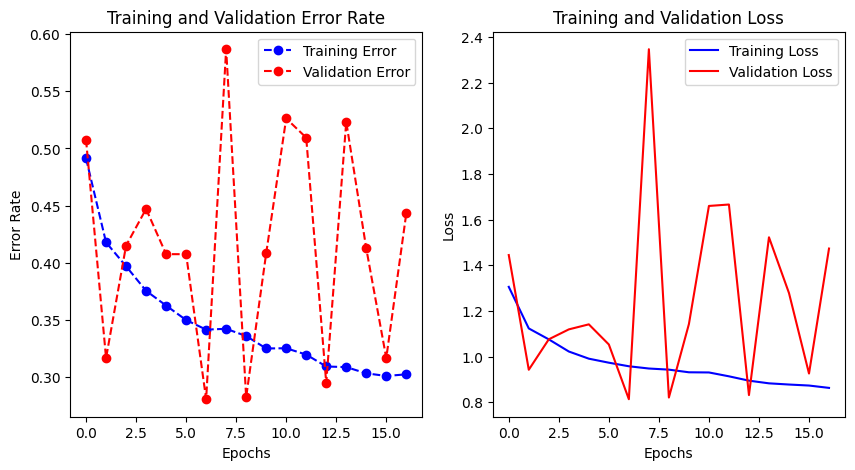

351/351 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step

Results for ResNet50:
  Train - Precision: 0.7741, Recall: 0.7439, F1-Score: 0.7438, AUC: 0.9529
  Validation - Precision: 0.7551, Recall: 0.7193, F1-Score: 0.7199, AUC: 0.9443
  Test - Precision: 0.7532, Recall: 0.7217, F1-Score: 0.7213, AUC: 0.9424


In [8]:
model_name = 'ResNet50'  # 替换为 'ResNet101', 'EfficientNetB0', 或 'VGG16' 以运行其他模型

print(f"Training {model_name}...")

model = create_model(model_name, input_shape=(224, 224, 3), num_classes=6)

history = train_model(
    model, 
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    epochs=50, 
    batch_size=5
)

plot_history(history)

train_precision, train_recall, train_f1, train_auc = evaluate_model(model, train_images, train_labels)
val_precision, val_recall, val_f1, val_auc = evaluate_model(model, val_images, val_labels)
test_precision, test_recall, test_f1, test_auc = evaluate_model(model, test_images, test_labels)

results = {
    'train': {'precision': train_precision, 'recall': train_recall, 'f1_score': train_f1, 'auc_score': train_auc},
    'validation': {'precision': val_precision, 'recall': val_recall, 'f1_score': val_f1, 'auc_score': val_auc},
    'test': {'precision': test_precision, 'recall': test_recall, 'f1_score': test_f1, 'auc_score': test_auc}
}

print(f"\nResults for {model_name}:")
for dataset, scores in results.items():
    print(f"  {dataset.capitalize()} - Precision: {scores['precision']:.4f}, Recall: {scores['recall']:.4f}, "
          f"F1-Score: {scores['f1_score']:.4f}, AUC: {scores['auc_score']:.4f}")


Training ResNet101...
Epoch 1/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 132s 66ms/step - accuracy: 0.4141 - loss: 1.5514 - val_accuracy: 0.5623 - val_loss: 1.4453
Epoch 2/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 105s 59ms/step - accuracy: 0.5294 - loss: 1.2577 - val_accuracy: 0.5312 - val_loss: 1.3190
Epoch 3/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 106s 59ms/step - accuracy: 0.5524 - loss: 1.1786 - val_accuracy: 0.5806 - val_loss: 1.1412
Epoch 4/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 107s 59ms/step - accuracy: 0.5809 - loss: 1.1084 - val_accuracy: 0.5610 - val_loss: 1.1488
Epoch 5/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 108s 60ms/step - accuracy: 0.5804 - loss: 1.1072 - val_accuracy: 0.6986 - val_loss: 0.8433
Epoch 6/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 106s 59ms/step - accuracy: 0.6051 - loss: 1.0385 - val_accuracy: 0.6327 - val_loss: 0.9609
Epoch 7/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 108s 60ms/step - accuracy: 0.6145 - loss: 1.0149 - val_accuracy: 0.5548 - val_loss: 1.2166
Epoch 8/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 108s 

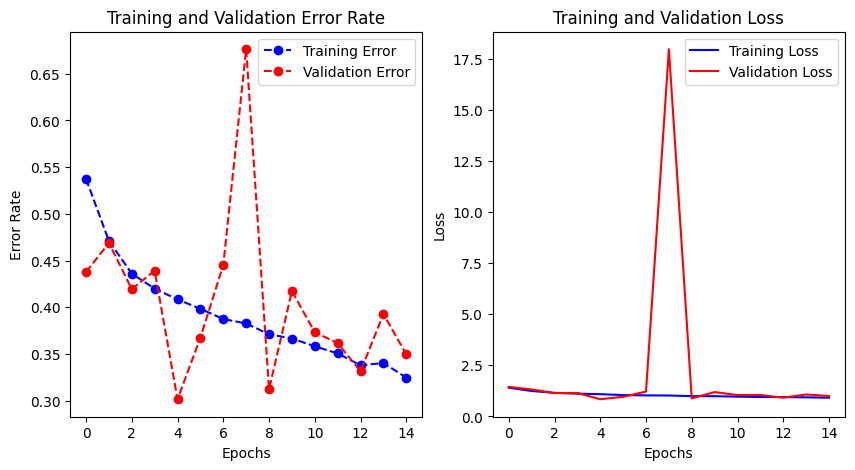

281/281 ━━━━━━━━━━━━━━━━━━━━ 51s 165ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step

Results for ResNet101:
  Train - Precision: 0.7247, Recall: 0.7162, F1-Score: 0.7161, AUC: 0.9394
  Validation - Precision: 0.7084, Recall: 0.6986, F1-Score: 0.6983, AUC: 0.9285
  Test - Precision: 0.6950, Recall: 0.6833, F1-Score: 0.6845, AUC: 0.9272


In [13]:
model_name = 'ResNet101'  # 替换为 'ResNet101', 'EfficientNetB0', 或 'VGG16' 以运行其他模型

print(f"Training {model_name}...")

model = create_model(model_name, input_shape=(224, 224, 3), num_classes=6)

history = train_model(
    model, 
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    epochs=50, 
    batch_size=5
)

plot_history(history)

train_precision, train_recall, train_f1, train_auc = evaluate_model(model, train_images, train_labels)
val_precision, val_recall, val_f1, val_auc = evaluate_model(model, val_images, val_labels)
test_precision, test_recall, test_f1, test_auc = evaluate_model(model, test_images, test_labels)

results = {
    'train': {'precision': train_precision, 'recall': train_recall, 'f1_score': train_f1, 'auc_score': train_auc},
    'validation': {'precision': val_precision, 'recall': val_recall, 'f1_score': val_f1, 'auc_score': val_auc},
    'test': {'precision': test_precision, 'recall': test_recall, 'f1_score': test_f1, 'auc_score': test_auc}
}

print(f"\nResults for {model_name}:")
for dataset, scores in results.items():
    print(f"  {dataset.capitalize()} - Precision: {scores['precision']:.4f}, Recall: {scores['recall']:.4f}, "
          f"F1-Score: {scores['f1_score']:.4f}, AUC: {scores['auc_score']:.4f}")


Training EfficientNetB0...


2024-12-16 02:16:22.695185: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2024-12-16 02:16:22.695246: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-12-16 02:16:22.695262: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-12-16 02:16:22.695332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 02:16:22.695353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-16 02:17:19.467487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1797/1797 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.1908 - loss: 2.1966 - val_accuracy: 0.1696 - val_loss: 2.2103
Epoch 2/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.2227 - loss: 1.9516 - val_accuracy: 0.1563 - val_loss: 3.6398
Epoch 3/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - accuracy: 0.2431 - loss: 1.8697 - val_accuracy: 0.2591 - val_loss: 1.7282
Epoch 4/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - accuracy: 0.2470 - loss: 1.8208 - val_accuracy: 0.1630 - val_loss: 2.0055
Epoch 5/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.2490 - loss: 1.7844 - val_accuracy: 0.2346 - val_loss: 2.0385
Epoch 6/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - accuracy: 0.2722 - loss: 1.7437 - val_accuracy: 0.2137 - val_loss: 1.9261
Epoch 7/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.2689 - loss: 1.7368 - val_accuracy: 0.2578 - val_loss: 1.8662
Epoch 8/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.2803 - loss: 1.68

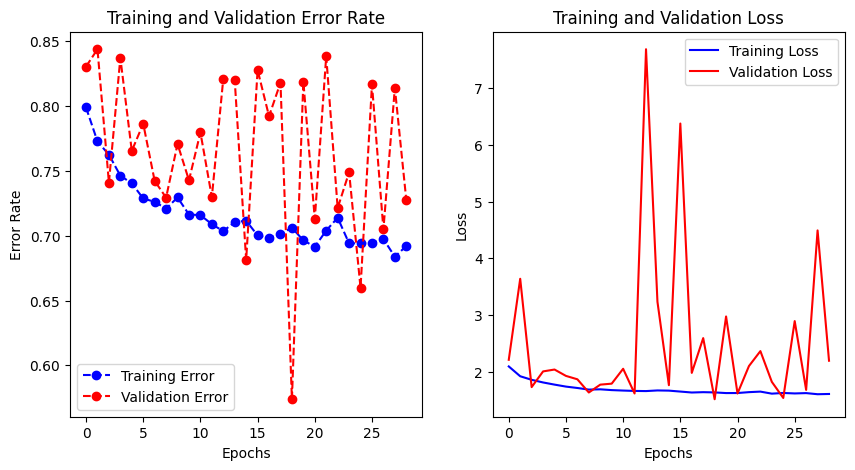

281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step

Results for EfficientNetB0:
  Train - Precision: 0.2837, Recall: 0.4084, F1-Score: 0.3087, AUC: 0.8076
  Validation - Precision: 0.2807, Recall: 0.4261, F1-Score: 0.3265, AUC: 0.8106
  Test - Precision: 0.2574, Recall: 0.4003, F1-Score: 0.3032, AUC: 0.8027


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
model_name = 'EfficientNetB0'  # 替换为 'ResNet101', 'EfficientNetB0', 或 'VGG16' 以运行其他模型

print(f"Training {model_name}...")

model = create_model(model_name, input_shape=(224, 224, 3), num_classes=6)

history = train_model(
    model, 
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    epochs=50, 
    batch_size=5
)

plot_history(history)

train_precision, train_recall, train_f1, train_auc = evaluate_model(model, train_images, train_labels)
val_precision, val_recall, val_f1, val_auc = evaluate_model(model, val_images, val_labels)
test_precision, test_recall, test_f1, test_auc = evaluate_model(model, test_images, test_labels)

results = {
    'train': {'precision': train_precision, 'recall': train_recall, 'f1_score': train_f1, 'auc_score': train_auc},
    'validation': {'precision': val_precision, 'recall': val_recall, 'f1_score': val_f1, 'auc_score': val_auc},
    'test': {'precision': test_precision, 'recall': test_recall, 'f1_score': test_f1, 'auc_score': test_auc}
}

print(f"\nResults for {model_name}:")
for dataset, scores in results.items():
    print(f"  {dataset.capitalize()} - Precision: {scores['precision']:.4f}, Recall: {scores['recall']:.4f}, "
          f"F1-Score: {scores['f1_score']:.4f}, AUC: {scores['auc_score']:.4f}")


Training VGG16...
Epoch 1/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 79s 43ms/step - accuracy: 0.6961 - loss: 1.0355 - val_accuracy: 0.8700 - val_loss: 0.5376
Epoch 2/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.8336 - loss: 0.6213 - val_accuracy: 0.8869 - val_loss: 0.4692
Epoch 3/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.8618 - loss: 0.5364 - val_accuracy: 0.8851 - val_loss: 0.4539
Epoch 4/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.8696 - loss: 0.4758 - val_accuracy: 0.8914 - val_loss: 0.3945
Epoch 5/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.8785 - loss: 0.4195 - val_accuracy: 0.8945 - val_loss: 0.3802
Epoch 6/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.8858 - loss: 0.3940 - val_accuracy: 0.8958 - val_loss: 0.3625
Epoch 7/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - accuracy: 0.8838 - loss: 0.3997 - val_accuracy: 0.8838 - val_loss: 0.3949
Epoch 8/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 67s 37ms/step - 

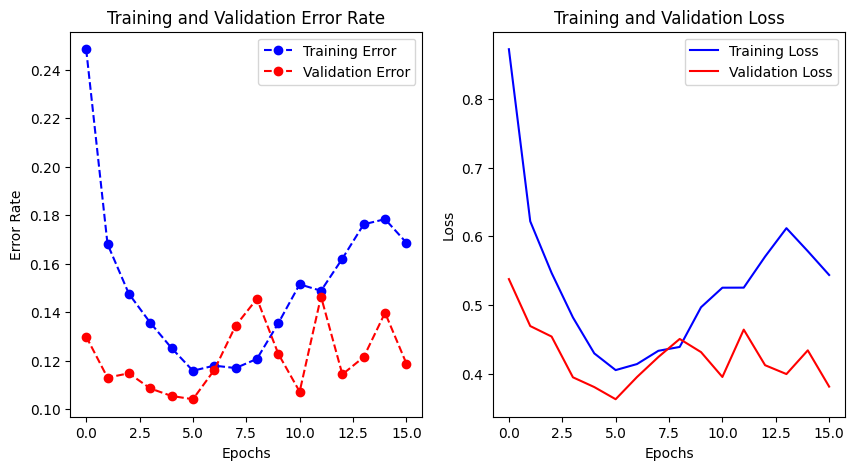

281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step

Results for VGG16:
  Train - Precision: 0.9288, Recall: 0.9281, F1-Score: 0.9281, AUC: 0.9935
  Validation - Precision: 0.8959, Recall: 0.8958, F1-Score: 0.8956, AUC: 0.9871
  Test - Precision: 0.8852, Recall: 0.8850, F1-Score: 0.8846, AUC: 0.9849


In [12]:
model_name = 'VGG16'  # 替换为 'ResNet101', 'EfficientNetB0', 或 'VGG16' 以运行其他模型

print(f"Training {model_name}...")

model = create_model(model_name, input_shape=(224, 224, 3), num_classes=6)

history = train_model(
    model, 
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    epochs=50, 
    batch_size=5
)

plot_history(history)

train_precision, train_recall, train_f1, train_auc = evaluate_model(model, train_images, train_labels)
val_precision, val_recall, val_f1, val_auc = evaluate_model(model, val_images, val_labels)
test_precision, test_recall, test_f1, test_auc = evaluate_model(model, test_images, test_labels)

results = {
    'train': {'precision': train_precision, 'recall': train_recall, 'f1_score': train_f1, 'auc_score': train_auc},
    'validation': {'precision': val_precision, 'recall': val_recall, 'f1_score': val_f1, 'auc_score': val_auc},
    'test': {'precision': test_precision, 'recall': test_recall, 'f1_score': test_f1, 'auc_score': test_auc}
}

print(f"\nResults for {model_name}:")
for dataset, scores in results.items():
    print(f"  {dataset.capitalize()} - Precision: {scores['precision']:.4f}, Recall: {scores['recall']:.4f}, "
          f"F1-Score: {scores['f1_score']:.4f}, AUC: {scores['auc_score']:.4f}")


Combining the performance of the four models, VGG16 performed best on the training set, validation set, and test set, with Precision, Recall, and F1-Score all close to 0.9, and AUC reaching 0.99, showing good classification ability and stability, and the training and validation error curves were relatively smooth. The validation errors of ResNet101 and ResNet50 fluctuated greatly, and their generalization ability was insufficient, which may be due to limited data or unsatisfactory parameter settings. EfficientNetB0 performed the worst, with low Precision and F1-Score, and AUC of only about 0.80, indicating that the model feature learning was insufficient. I have repeatedly tried data enhancement, learning rate adjustment, and different parameter settings in the past few days, but the results are still not ideal. Next, I will continue to optimize data enhancement methods, adjust model structure and training parameters, and increase data diversity to further improve the generalization ability of the model.